# Diagnostics of a simulation with python using dask and xorca

## Loading the libraries

In [1]:
%load_ext memory_profiler
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from xorca.lib import load_xorca_dataset

In [4]:
# Personal modification to xorca
from __param__ import *
from tools_xorca import complete_dataset
from calculate_xorca import calculate_speed, calculate_psi, calculate_moc, calculate_enso, average_2D, average_3D

In [5]:
import importlib, sys
importlib.reload(sys.modules['calculate_xorca'])
from calculate_xorca import calculate_speed, calculate_psi, calculate_moc, calculate_enso, average_2D, average_3D

In [18]:
import dask
from dask.distributed import Client
client = Client(scheduler_file='/esarchive/scratch/tarsouze/scheduler.json')
dask.set_options(get=client.get)
client

Client Scheduler: tcp://84.88.185.115:8786 Dashboard: http://84.88.185.115:8787/status,Cluster Workers: 4 Cores: 4 Memory: 96.00 GB


## Preparing the dataset (variables + grid info)

In [ ]:
#General definitions
config = 'ORCA1L75'
exp    = 'a13c'
data_path     = Path("/esnas/exp/ecearth/a13c/original_files/19500101/fc0/outputs")
data_path_aux = Path(coordinates_path+config)

#Data files
data_files_u  = list(sorted(data_path.glob(exp+"_1m_200[01]*grid_U.nc")))
data_files_v  = list(sorted(data_path.glob(exp+"_1m_200[01]*grid_V.nc")))
data_files_t  = list(sorted(data_path.glob(exp+"_1m_200[01]*grid_T.nc")))
data_files_sbc  = list(sorted(data_path.glob(exp+"_1m_200[01]*SBC.nc")))
aux_files_m   = list(sorted(data_path_aux.glob("mesh*")))
aux_files_s   = list(sorted(data_path_aux.glob("subbasins.nc")))
aux_files_b   = list(sorted(data_path_aux.glob("basin_mask_ORCA1_ece3.2_2017.nc4")))

data_files    = data_files_u+data_files_v+data_files_t
aux_files     = aux_files_m+aux_files_s+aux_files_b

In [ ]:
#Actualy load the data
ds_xorca = load_xorca_dataset(data_files=data_files, aux_files=aux_files,
                              decode_cf=True, 
                              input_ds_chunks=input_chunks_ORCA1L75,
                              target_ds_chunks=target_chunks_ORCA1L75,
                              update_orca_variables=update_orca_variables)

In [ ]:
#Add area and volume of the grid to the coordinates
ds_xorca = complete_dataset(ds_xorca)

In [ ]:
ds_xorca

In [ ]:
print('ds size in GB {:0.2f}\n'.format(ds_xorca.nbytes / 1e9))

Ok ! Our dataset is ready

## Horizontal average

### Test with a 2D variable

In [91]:
var='pbo'
ave = average_2D(ds_xorca,var)
ave_yearly_rolling = ave.rolling(t=12, center=True).mean()

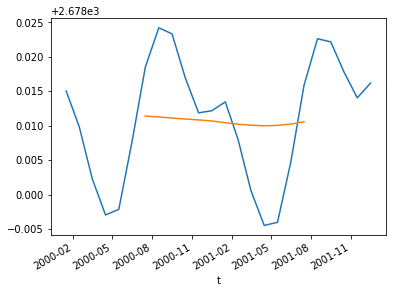

In [92]:
ave.plot()
ave_yearly_rolling.plot()

In [93]:
ave

<xarray.DataArray (t: 24)>
array([2678.01502 , 2678.009844, 2678.002285, 2677.997041, 2677.997844,
       2678.007687, 2678.018476, 2678.024191, 2678.023301, 2678.016928,
       2678.01185 , 2678.01216 , 2678.013434, 2678.007952, 2678.000552,
       2677.995516, 2677.995967, 2678.004671, 2678.01583 , 2678.0226  ,
       2678.022146, 2678.017772, 2678.014027, 2678.016168])
Coordinates:
  * t        (t) datetime64[ns] 2000-01-16T12:00:00 2000-02-15T12:00:00 ...

### Test with a 3D variable

In [81]:
var='thetao'
ave = average_2D(ds_xorca,var)
ave_yearly_rolling = ave.rolling(t=12, center=True).mean()
ave.compute();ave_yearly_rolling.compute();

In [82]:
ave_yearly=ave.groupby('t.year').mean(dim='t')

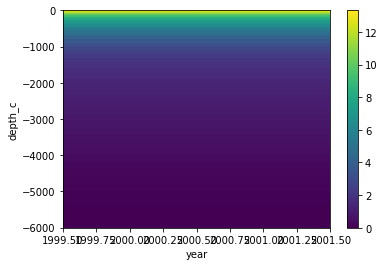

In [83]:
ave_yearly.plot(x='year',y='depth_c')

### Loop, both on variables and basins masks

In [191]:
list_vars = ['pbo','zos']
masks = [key for key in ds_xorca.coords.keys() if key.startswith('tmask')]
averages = []
for mask in masks:
    if mask != 'tmask':
        ds = ds_xorca.where(ds_xorca[mask],drop=True)    
    else:
        ds = ds_xorca
    for var in list_vars:
        ave = average_2D(ds,var)
        ave.name=var+'_'+mask+'_have'
        averages.append(ave)

In [192]:
ds=[]
for (i,var) in enumerate(list_vars):
    vars = [diag for diag in averages if diag.name.startswith(var)]
    ds.append(xr.concat(vars,dim='basins').rename(var+"_2D_ave"))
ds = xr.merge(ds)
ds.coords['basins'] = masks
ds_yearly_rolling = ds.rolling(t=12, center=True).mean()

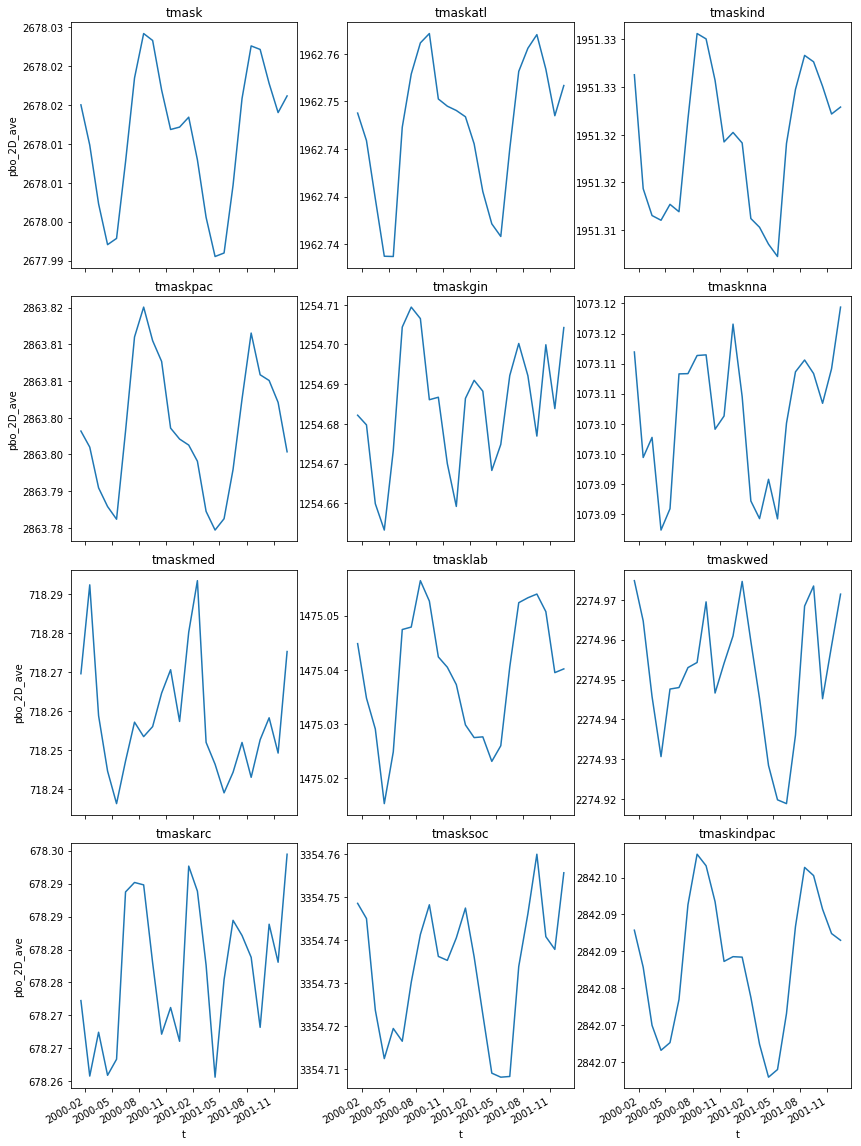

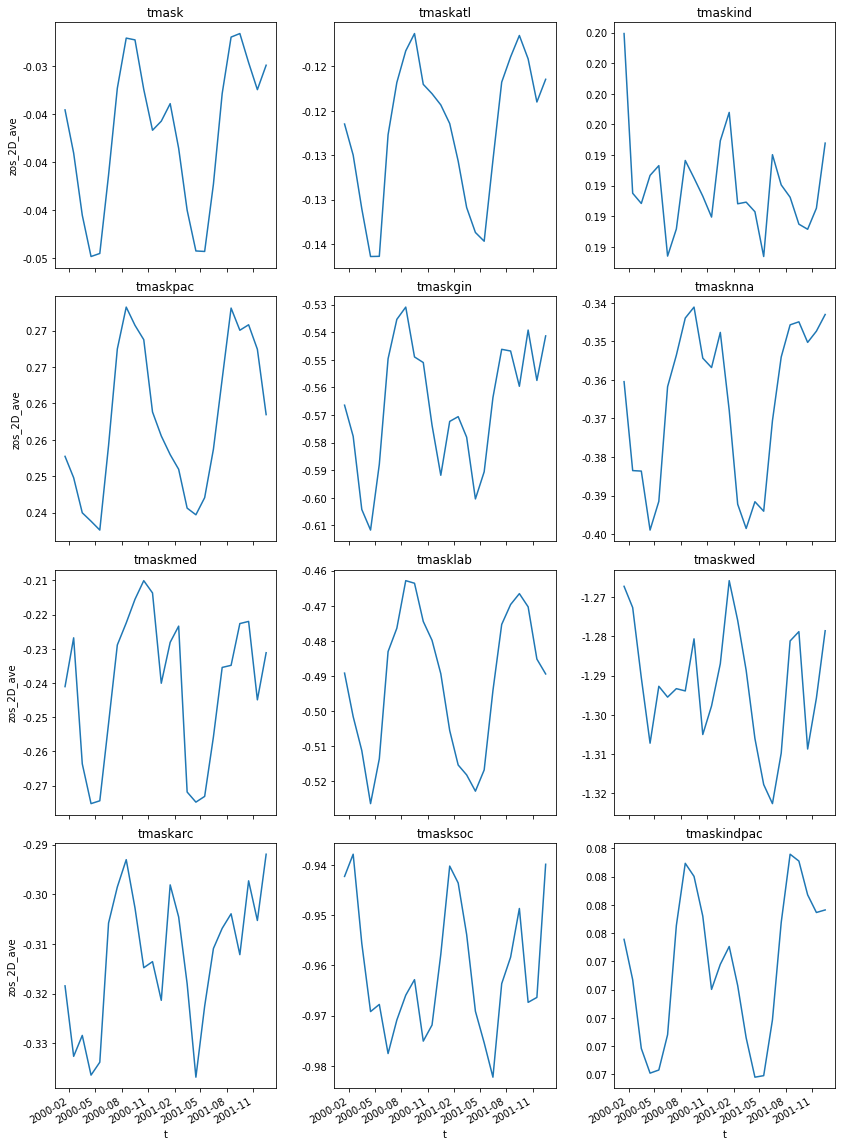

In [199]:
for var in ds.data_vars:
    ax=ds[var].plot(col='basins',col_wrap=3,sharey=False, figsize=[12,16])
    for (i,g) in enumerate(ax.axes.flat):
        g.set_title(ds.basins[i].values)
        vals = g.get_yticks()
        g.set_yticklabels(['{:04.2f}'.format(x) for x in vals])
    plt.savefig(var+'.png')

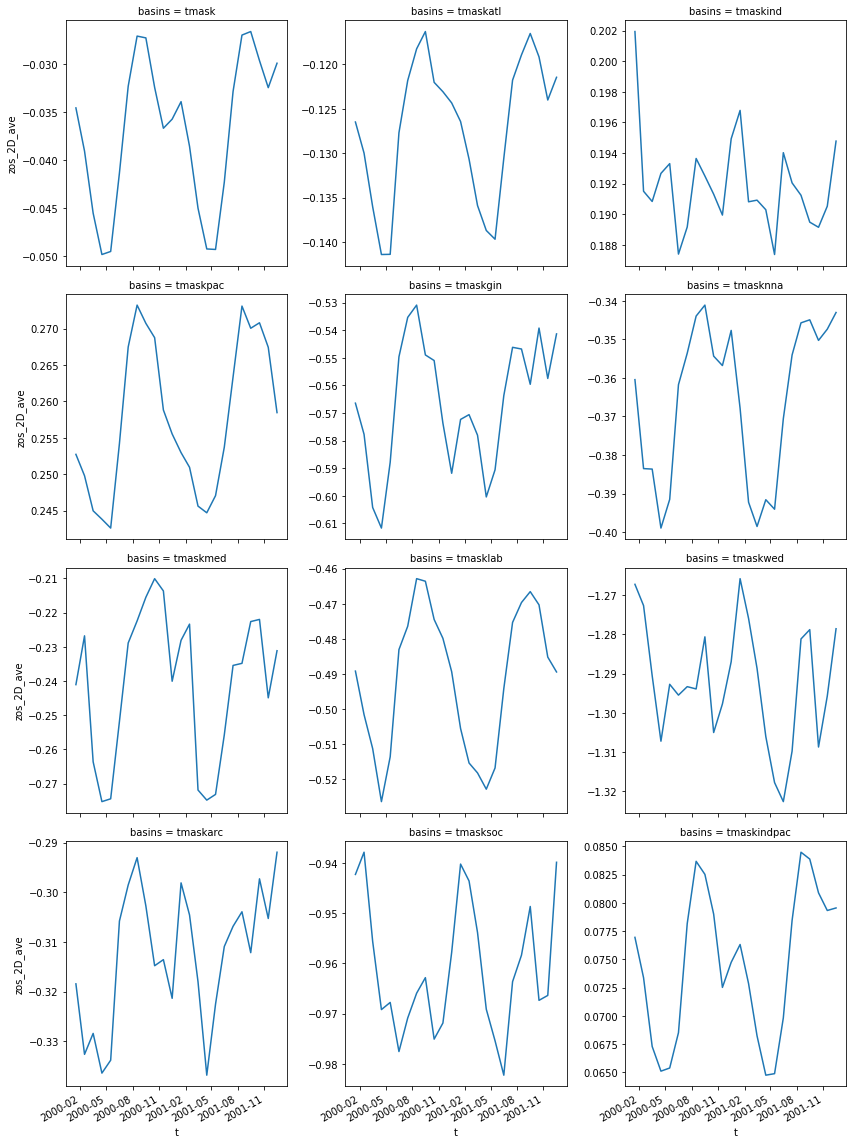

In [195]:
ds.zos_2D_ave.plot(col='basins',col_wrap=3,sharey=False, figsize=[12,16])

## 3D average (over depths layers)

### Test on one variable

In [32]:
var='thetao';depths=[0,100]
ave = average_3D(ds_xorca,var,depths)
ave_yearly_rolling = ave.rolling(t=12, center=True).mean()
ave.compute();ave_yearly_rolling.compute();

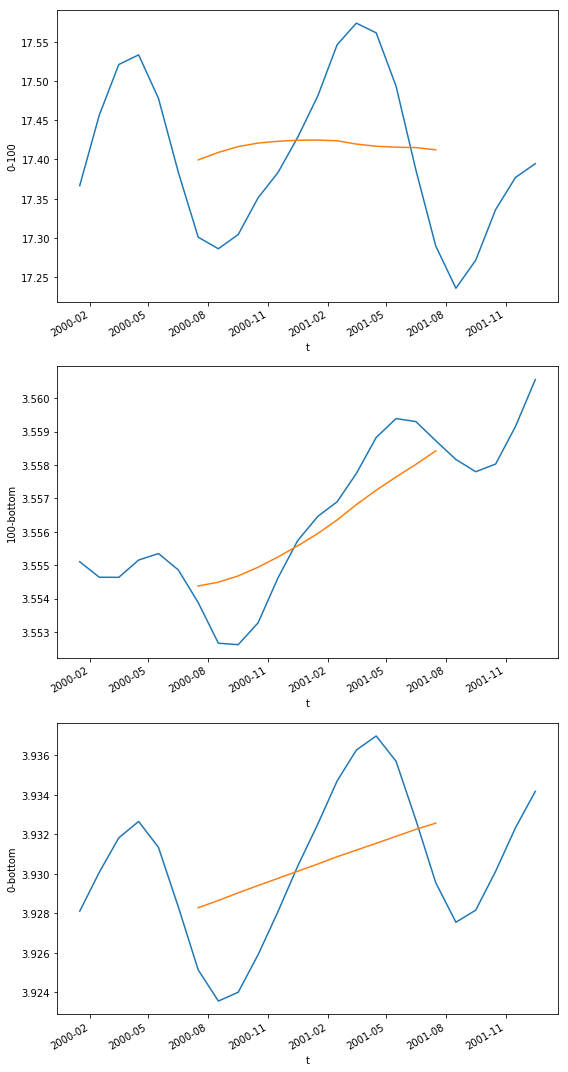

In [34]:
fig, axarr = plt.subplots(ncols=1, nrows=len(ave.var()), figsize=[8,15])
for i,var in enumerate(ave.var()):
    ax = axarr[i]
    ave[var].plot(ax=ax)
    ave_yearly_rolling[var].plot(ax=ax)
    
plt.tight_layout()

### Now in a loop (both masks and variables)

In [18]:
list_vars = ['so','thetao']
depths=[0]
masks = [key for key in ds_xorca.coords.keys() if key.startswith('tmask')]
averages = []
for mask in masks:
    ds = ds_xorca.where(ds_xorca[mask],drop=True)    
    for var in list_vars:
        ave = average_3D(ds,var)
        averages.append(ave)
        
ds = xr.merge(averages)
ds_yearly_rolling = ds.rolling(t=12, center=True).mean()

MergeError: conflicting values for variable '0-bottom' on objects to be combined:
first value: <xarray.Variable (t: 24)>
dask.array<shape=(24,), dtype=float64, chunksize=(12,)>
second value: <xarray.Variable (t: 24)>
dask.array<shape=(24,), dtype=float64, chunksize=(12,)>

In [ ]:
ds

## ENSO

In [56]:
enso = calculate_enso(ds_xorca.tos)

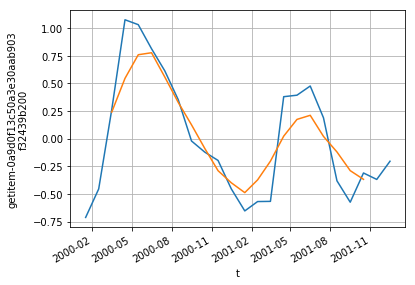

In [68]:
fig, ax = plt.subplots()
enso.plot(ax=ax, label='raw')
ax.grid()

## MOC

In [44]:
amoc = calculate_moc(ds_xorca, region="atl")
amoc

<xarray.DataArray 'mocatl' (y_r: 290, z_l: 75, t: 24)>
dask.array<shape=(290, 75, 24), dtype=float64, chunksize=(145, 1, 12)>
Coordinates:
  * y_r         (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
  * t           (t) datetime64[ns] 2000-01-16T12:00:00 2000-02-15T12:00:00 ...
    lat_mocatl  (y_r) float64 dask.array<shape=(290,), chunksize=(145,)>
    depth_l     (z_l) float64 dask.array<shape=(75,), chunksize=(25,)>

### Plot with proper coordinates

Note that in the North, the latitutde not necessarily increases monotonically. To fix this, we first sort the amoc_mean and amoc_std by their latitude coordinates. We also restrict to everything North of 35°N and we mask.

In [49]:
amoc = amoc.sortby("lat_mocatl")
amoc = amoc.where(amoc["lat_mocatl"] > -35.0, drop=True)

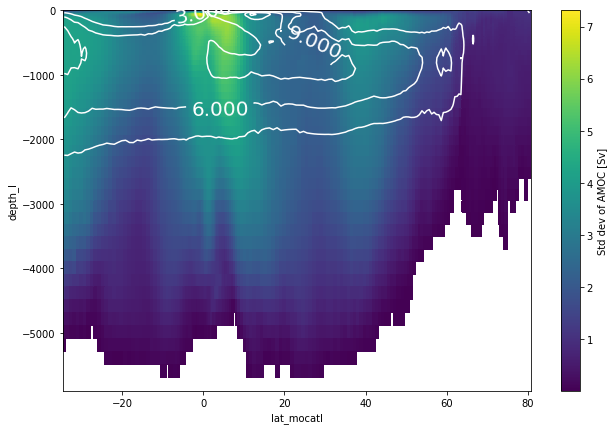

In [51]:
amoc_mean = amoc.mean("t").rename("Mean of AMOC [Sv]")
amoc_mean = amoc_mean.where(amoc_mean > 1.0e-7)

amoc_std = amoc.std("t").rename("Std dev of AMOC [Sv]")
amoc_std = amoc_std.where(amoc_std > 1.0e-7)

amoc_std.plot.pcolormesh("lat_mocatl", "depth_l", size=7);

cs = amoc_mean.plot.contour("lat_mocatl", "depth_l", colors='white');
plt.clabel(cs, fontsize=20, inline=1);


## Barotropic Stream Function

In [24]:
%%time
psi = calculate_psi(ds_xorca)
psi

CPU times: user 727 ms, sys: 258 ms, total: 985 ms
Wall time: 4.32 s


CPU times: user 14.3 s, sys: 17.3 s, total: 31.6 s
Wall time: 45.4 s


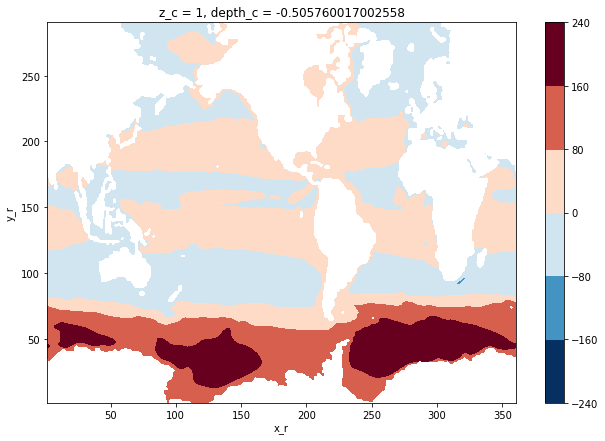

In [25]:
%%time
psi_m = psi.mean("t").where(ds_xorca.fmask.isel(z_c=0)).compute()
psi_m.plot.contourf(size=7);

## Velocities

In [71]:
%%time
speed = calculate_speed(ds_xorca)
speed = speed.where(ds_xorca.tmask == 1.0)

CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 116 ms


In [72]:
speed

<xarray.DataArray (t: 24, z_c: 75, y_c: 290, x_c: 360)>
dask.array<shape=(24, 75, 290, 360), dtype=float32, chunksize=(12, 25, 1, 1)>
Coordinates:
  * t            (t) datetime64[ns] 2000-01-16T12:00:00 2000-02-15T12:00:00 ...
  * z_c          (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * y_c          (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * x_c          (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    depth_c      (z_c) float64 dask.array<shape=(75,), chunksize=(25,)>
    llat_cc      (y_c, x_c) float32 dask.array<shape=(290, 360), chunksize=(145, 60)>
    llon_cc      (y_c, x_c) float32 dask.array<shape=(290, 360), chunksize=(145, 60)>
    e1t          (y_c, x_c) float64 dask.array<shape=(290, 360), chunksize=(145, 60)>
    e2t          (y_c, x_c) float64 dask.array<shape=(290, 360), chunksize=(145, 60)>
    e3t          (z_c, y_c, x_c) float64 dask.array<shape=(75, 290, 360), chunksize=(25, 145, 60)>
    tmask      

## Kinetic energy

## Transport through sections

In [201]:
name="DRAKE-PASSAGE"
rau0=1025.  
rcp=3990.

trpu = ds.uo * ds.e3u * ds.e2u
trpv = ds.vo * ds.e3v * ds.e1v
trput = trpu * grid.interp(ds_xorca.thetao,'X') * rau0 * rcp
trpvt = trpv * grid.interp(ds_xorca.thetao,'Y') * rau0 * rcp
trpus = trpu * grid.interp(ds_xorca.so,'X')
trpvs = trpv * grid.interp(ds_xorca.so,'Y')

In [221]:
fname="/home/Earth/tarsouze/tmp/broken_line_"+section+".dat"
points=[]
maskMFO_u = xr.DataArray(np.zeros((ds_xorca.dims['y_c'],ds_xorca.dims['x_r']), dtype=np.int16),dims=('y_c','x_r'),name= 'maskMFO_u')
maskMFO_v = xr.DataArray(np.zeros((ds_xorca.dims['y_r'],ds_xorca.dims['x_c']), dtype=np.int16),dims=('y_r','x_c'),name= 'maskMFO_v')
with open(fname) as f:
    next(f)
    for line in f:
       points.append(line.split())

for l in range(len(points)-1):
    if (points[l+1][0]==points[l][0]):
       if (int(points[l+1][1])==int(points[l][1])+1):
          maskMFO_u[int(points[l][1]),int(points[l][0])-1]=1
       else:
          maskMFO_u[int(points[l][1])-1,int(points[l][0])-1]=1
    if (points[l+1][1]==points[l][1]):
       if (int(points[l+1][0])==int(points[l][0])+1):
           maskMFO_v[int(points[l][1])-1,int(points[l][0])]=1
       else:
           maskMFO_v[int(points[l][1])-1,int(points[l][0])-1]=1

norm_u=1
norm_v=1
depth1=0
depth2=100

In [224]:
depth = [key for key in ds.coords.keys() if key.startswith('depth')][0]
condition = ((-ds[depth]>depth1) & (-ds[depth]<depth2))
arrayv = trpu.where(condition & maskMFO_u).sum(trpu.dims[-3:])*norm_u + trpv.where(condition & maskMFO_v).sum(trpv.dims[-3:])*norm_v

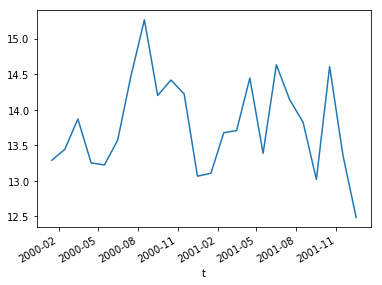

In [226]:
(arrayv*1e-6).plot()

## Wind stress curl

In [9]:
grid = xgcm.Grid(ds_xorca, periodic=["Y", "X"])
curl = (grid.diff(ds_xorca.tauvo * ds_xorca.e1v, 'X') + grid.diff(ds_xorca.tauuo * ds_xorca.e2u, 'Y'))/grid.interp(ds_xorca.uarea,'Y')

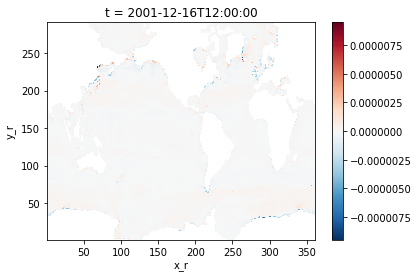

In [13]:
curl.isel(t=23).plot()

## Vorticity and Strain

In [15]:
strain = (grid.diff(ds_xorca.uo * ds_xorca.e2u, 'X') + grid.diff(ds_xorca.vo * ds_xorca.e1v, 'Y'))/ds_xorca.tarea
strain


<xarray.DataArray (t: 24, z_c: 75, y_c: 290, x_c: 360)>
dask.array<shape=(24, 75, 290, 360), dtype=float64, chunksize=(12, 25, 1, 1)>
Coordinates:
  * t            (t) datetime64[ns] 2000-01-16T12:00:00 2000-02-15T12:00:00 ...
  * z_c          (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * y_c          (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * x_c          (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    llat_cc      (y_c, x_c) float32 dask.array<shape=(290, 360), chunksize=(145, 60)>
    llon_cc      (y_c, x_c) float32 dask.array<shape=(290, 360), chunksize=(145, 60)>
    e1t          (y_c, x_c) float64 dask.array<shape=(290, 360), chunksize=(145, 60)>
    e2t          (y_c, x_c) float64 dask.array<shape=(290, 360), chunksize=(145, 60)>
    tmaskatl     (y_c, x_c) float32 dask.array<shape=(290, 360), chunksize=(145, 60)>
    tmaskind     (y_c, x_c) float32 dask.array<shape=(290, 360), chunksize=(145, 60)>
    tmaskpac  